# Connaître ses clients

Une des applications les plus courantes du KMeans est d’apprendre à connaître ses clients. Prenez un dataset très simple qui est Mall Customers pour essayer de découvrir des segmentations clients.


0. Importez les librairies usuelles 

In [0]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt

In [0]:
dataset = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv")
dataset.head()

,Date/Time,Lat,Lon,Base
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512
2,6/1/2014 0:04:00,40.3461,-74.6610,B02512
3,6/1/2014 0:04:00,40.7555,-73.9833,B02512
4,6/1/2014 0:07:00,40.6880,-74.1831,B02512


In [0]:
dataset.describe()

,Lat,Lon
count,663844.000000,663844.000000
mean,40.739884,-73.974073
std,0.038387,0.056647
min,39.955800,-74.859400
25%,40.721900,-73.996700
50%,40.743700,-73.983500
75%,40.761300,-73.967600
max,41.319900,-72.696600


In [0]:
X=dataset.sample(5000)

In [0]:
from dateutil import parser
X['Date/Time'] = X['Date/Time'].apply(lambda x :   parser.parse(x))
X['Day'] = pd.DataFrame(X['Date/Time'].dt.day) 
X['Month'] = pd.DataFrame(X['Date/Time'].dt.month) 
X['Year'] = pd.DataFrame(X['Date/Time'].dt.year)

X.head()

,Date/Time,Lat,Lon,Base,Day,Month,Year
432864,2014-06-26 22:11:00,40.7435,-73.9198,B02617,26,6,2014
65770,2014-06-05 08:57:00,40.6834,-73.9969,B02598,5,6,2014
649200,2014-06-29 21:06:00,40.7475,-73.9443,B02682,29,6,2014
419766,2014-06-25 15:14:00,40.7505,-73.9717,B02617,25,6,2014
196731,2014-06-20 15:04:00,40.7619,-73.9704,B02598,20,6,2014


In [0]:
X['Date/Time'] = pd.to_datetime(X['Date/Time'], format='%H:%M')
a = X.assign(session=pd.cut(X['Date/Time'].dt.hour,[-1,6,12,18,24],labels=['Night','Morning','Afternoon','Evening']))
X['Moment_of_day'] = a['session']
X.head()

,Date/Time,Lat,Lon,Base,Day,Month,Year,Moment_of_day
432864,2014-06-26 22:11:00,40.7435,-73.9198,B02617,26,6,2014,Evening
65770,2014-06-05 08:57:00,40.6834,-73.9969,B02598,5,6,2014,Morning
649200,2014-06-29 21:06:00,40.7475,-73.9443,B02682,29,6,2014,Evening
419766,2014-06-25 15:14:00,40.7505,-73.9717,B02617,25,6,2014,Afternoon
196731,2014-06-20 15:04:00,40.7619,-73.9704,B02598,20,6,2014,Afternoon


In [0]:
# On supprime les features qui nous paraissent inutiles à l'entrainement de nos futurs modèles
X = X.drop(['Date/Time','Month','Year'], axis=1)
X.head()

,Lat,Lon,Base,Day,Moment_of_day
432864,40.7435,-73.9198,B02617,26,Evening
65770,40.6834,-73.9969,B02598,5,Morning
649200,40.7475,-73.9443,B02682,29,Evening
419766,40.7505,-73.9717,B02617,25,Afternoon
196731,40.7619,-73.9704,B02598,20,Afternoon


In [0]:
# Dummyfication
X = pd.get_dummies(X)
X.head()

,Lat,Lon,Day,Base_B02512,Base_B02598,Base_B02617,Base_B02682,Base_B02764,Moment_of_day_Night,Moment_of_day_Morning,Moment_of_day_Afternoon,Moment_of_day_Evening
432864,40.7435,-73.9198,26,0,0,1,0,0,0,0,0,1
65770,40.6834,-73.9969,5,0,1,0,0,0,0,1,0,0
649200,40.7475,-73.9443,29,0,0,0,1,0,0,0,0,1
419766,40.7505,-73.9717,25,0,0,1,0,0,0,0,1,0
196731,40.7619,-73.9704,20,0,1,0,0,0,0,0,1,0


In [0]:
X.describe()

,Lat,Lon,Day,Base_B02512,Base_B02598,Base_B02617,Base_B02682,Base_B02764,Moment_of_day_Night,Moment_of_day_Morning,Moment_of_day_Afternoon,Moment_of_day_Evening
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,40.740127,-73.974361,15.411200,0.048800,0.374200,0.270200,0.292200,0.014600,0.112200,0.240000,0.377200,0.270600
std,0.038720,0.054069,8.403894,0.215471,0.483964,0.444107,0.454819,0.119957,0.315644,0.427126,0.484734,0.444314
min,40.484000,-74.472800,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.721875,-73.996425,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.743450,-73.983700,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.761500,-73.967200,23.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,41.136800,-73.489800,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_num = X.iloc[:,[0,1]]
X_cat = X.iloc[:,2:].to_numpy()
X_num = sc.fit_transform(X_num)
X_num

array([[ 0.08711154,  1.00920646],
       [-1.4652139 , -0.41690409],
       [ 0.19042771,  0.55603255],
       ...,
       [ 0.32215583,  1.58445987],
       [-0.13501822, -0.62221962],
       [-0.52761966, -0.66291278]])

In [0]:
X = np.concatenate([X_num,X_cat],axis=1)

1. Essayez de voir le nombre de clusters optimum

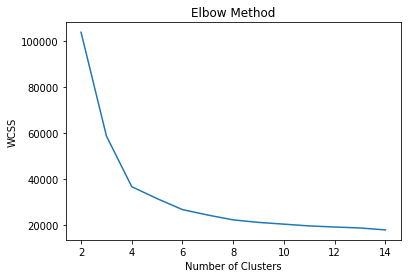

In [0]:
# Using the Elbow method to find the optimal number K of clusters
from sklearn.cluster import KMeans
wcss =  []
for i in range (2,15): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(2,15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

 -> Le nombre optimum de clusters semble être entre 4 et 6



For n_clusters = 3 The average silhouette_score is : 0.48923808828321136
For n_clusters = 4 The average silhouette_score is : 0.4762067135728021
For n_clusters = 5 The average silhouette_score is : 0.40773733472055157
For n_clusters = 6 The average silhouette_score is : 0.3596601814173083
For n_clusters = 7 The average silhouette_score is : 0.3117940481426747


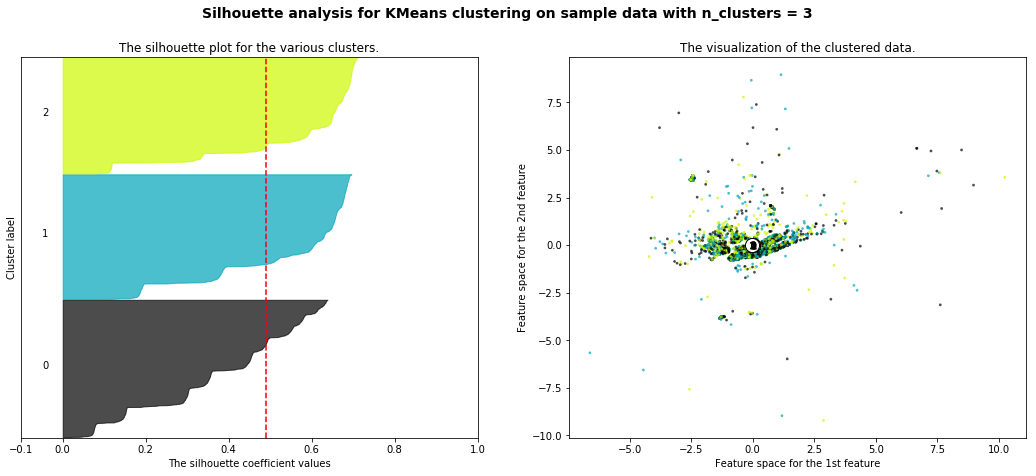

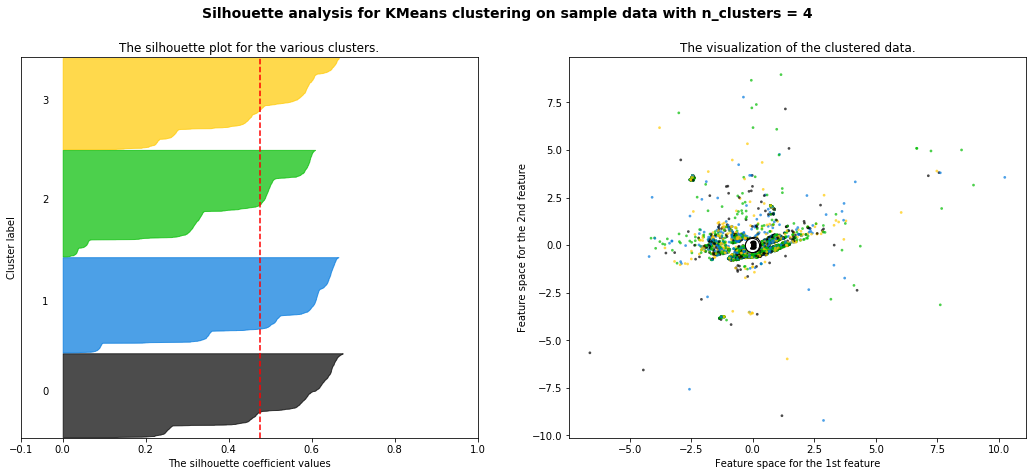

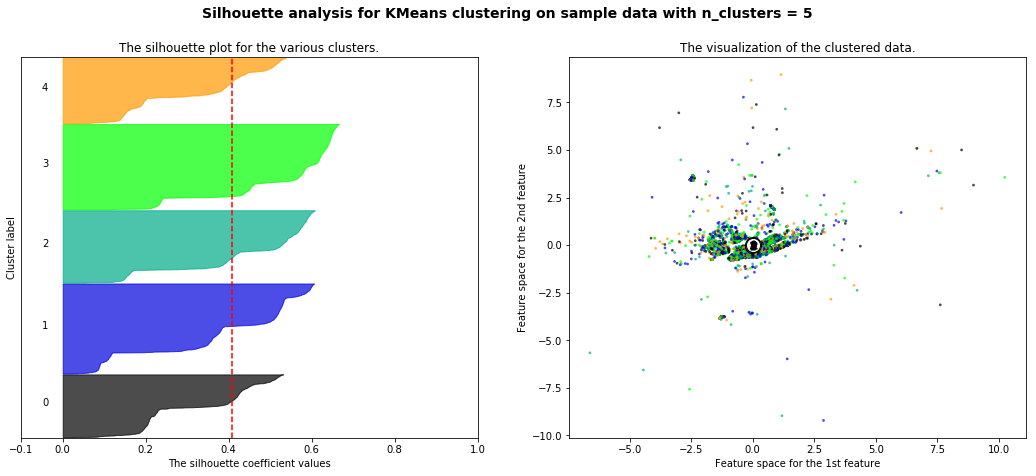

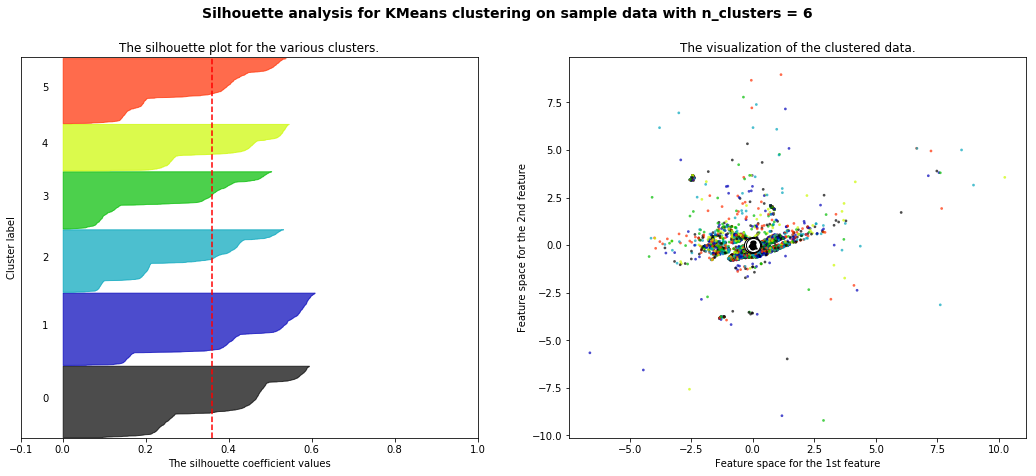

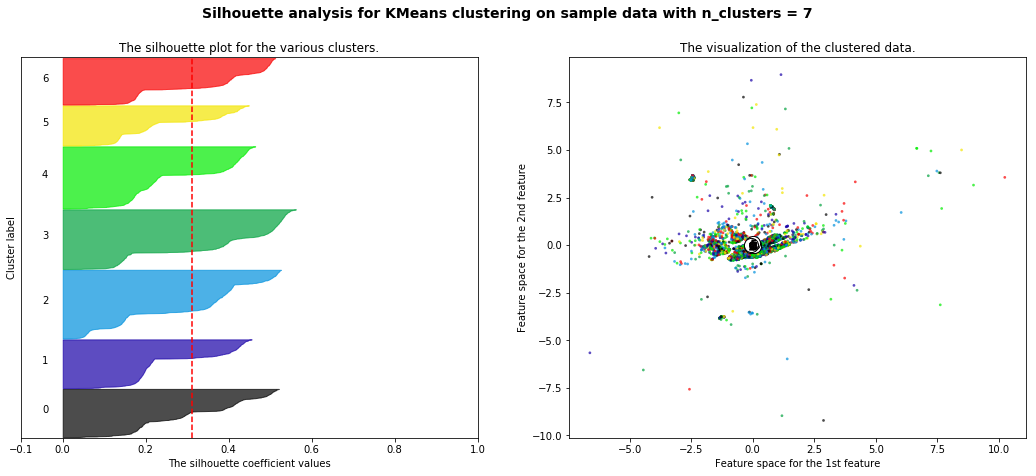

In [0]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

2. Trouver ces clusters sur une map

In [0]:
from scipy.cluster.vq import kmeans2, whiten

coordinates= X.var
x, y = kmeans2(whiten(coordinates), 3, iter = 20,)  
coordinates

ValueError: ignored

In [0]:
import folium
import json

centre = [40.71427, -74.00597]
ny = folium.Map(location = centre, zoom_start = 12)

for i in range(0,len(X)):
  folium.CircleMarker(coordinates[i],
          #Make color/style changes here
          icon =  folium.Icon(color='green'),
          ).add_to(ny)

In [0]:
ny

In [0]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.01, min_samples=10,metric='manhattan')
clustering

In [0]:
dbscan_predict = clustering.fit_predict(coordinates)
dbscan_predict

In [0]:
np.unique(dbscan_predict)

In [0]:
coordinates

In [0]:
import folium
import datetime as dt
import random as rnd
from folium.plugins import FastMarkerCluster
t0 = dt.datetime.now()
#New York City Coordinates
NYC_COORD = [40.7128, -74.0059]
# Sample (0.33% over 1.5 million)
centre = [40.71427, -74.00597]
# Build map
map_nyc = folium.Map(location=NYC_COORD, zoom_start=10,
tiles='cartodbpositron', width=864, height=680)
# Plot coordinates using comprehension list
#map_nyc.add_child(FastMarkerCluster(sample_coords))
colors = ["grey","blue",'red', "green", "yellow","orange","purple","pink","black","brown"]
for j in range (len(np.unique(dbscan_predict))) :
  sample_coords = X[dbscan_predict == j-1]
  geometry = [[x,y] for x,y in zip(sample_coords.Lat,sample_coords.Lon)]
  [folium.CircleMarker(geometry[i], radius=1,
               color=colors[j], fill_color=colors[j]).add_to(map_nyc)
  for i in range(len(geometry))]
  
map_nyc

In [0]:
len(X[dbscan_predict == j-1])